## RQ6

#### It's time to get information from the user posting effectiveness.

#### 6.1 What is the average time (days and minutes) a user lets pass before publishing another post? Plot the top 3 users that publish posts more frequently (calculate the average time that passes between posts), including their amount of followers and following. Provide insights from that chart.

##### Through the for loop and the established chunksize, we select only the columns of interest: profile_id and cts

In [3]:
import pandas as pd
from tqdm import tqdm

df_list = []

for chunk in tqdm(pd.read_csv('instagram_posts.csv', delimiter='\t', chunksize=500000)):
    
    filtered = chunk[['profile_id','cts']]
    
    df_list.append(filtered)

86it [03:12,  2.24s/it]


##### Through the lambda function, an append is made of all the 86 DataFrames that were obtained in the previous loop and they are saved in the DataFrame "post_dt_by_profile_id"

In [4]:
from functools import reduce

post_dt_by_profile_id = reduce(lambda df1, df2: df1.append(df2), df_list)

post_dt_by_profile_id.head(5)

,profile_id,cts
0,2.237948e+09,2017-08-06 20:06:57.000
1,5.579335e+09,2017-06-19 09:31:16.000
2,3.134296e+08,2017-03-11 20:05:03.000
3,1.837593e+09,2016-09-13 16:27:16.000
4,1.131527e+09,2015-10-18 10:19:27.000


##### A backup CSV file is saved

In [ ]:
post_dt_by_profile_id.to_csv('post_dt_by_profile_id.csv')

post_dt_by_profile_id = pd.read_csv('post_dt_by_profile_id.csv', header=0, index_col=0)

##### A window operation was performed to obtain the time delta that a user had between one operation and another.

##### A count was made to find out how many posts had been made per user and the DataFrame was restricted to analyze the average time between posts only for users who had made more than one post.

In [5]:
post_dt_by_profile_id.cts = pd.to_datetime(post_dt_by_profile_id.cts)

#Window operation 
post_dt_by_profile_id["_previous_time"] = ( 
    post_dt_by_profile_id.sort_values("cts").groupby("profile_id")["cts"].shift(1)
    )

post_dt_by_profile_id["_count_cts"] = post_dt_by_profile_id.groupby("profile_id")["cts"].transform("count")

post_dt_by_profile_id = post_dt_by_profile_id[post_dt_by_profile_id["_count_cts"] > 1].reset_index()

post_dt_by_profile_id["delta_time"] = post_dt_by_profile_id["cts"] - post_dt_by_profile_id["_previous_time"]

##### The columns of interest are saved in the DataFrame, the NaT values ​​are eliminated and we convert the DataFrame to Int64

In [6]:
post_dt_by_profile_id = post_dt_by_profile_id[['profile_id','delta_time']]

post_dt_by_profile_id = post_dt_by_profile_id[post_dt_by_profile_id["delta_time"].notna()]

post_dt_by_profile_id = post_dt_by_profile_id.astype('int64')

##### The average time that passes between posts was calculated using .mean() after a groupby per profile_id

In [12]:
post_dt_by_profile_id_mean = post_dt_by_profile_id \
    .groupby("profile_id")['delta_time'].mean().reset_index(name="mean")

##### The 3 people with the shortest average time were selected.

In [13]:
post_dt_by_profile_id_mean = post_dt_by_profile_id_mean.nsmallest(3,'mean')

#Use to have the mean time in Days.
post_dt_by_profile_id_mean = post_dt_by_profile_id_mean.astype({'profile_id':'int64', 'mean': 'timedelta64[ns]'})

post_dt_by_profile_id_mean

,profile_id,mean
125819,8801686,0.0
160364,11534437,0.0
256203,19420666,0.0


##### To verify why there are 3 users with an average of 0, a filter was made of all the posts that these users made.

In [14]:
top_3_smallest_mean = post_dt_by_profile_id_mean.profile_id.astype('int32').to_list()

from tqdm import tqdm

posts_list = []

for chunk in tqdm(pd.read_csv('instagram_posts.zip', delimiter='\t', chunksize=500000)):
    
    filtered = chunk[chunk.profile_id.isin(top_3_smallest_mean)]
    
    posts_list.append(filtered)

86it [04:04,  2.84s/it]


##### As you can see, these 3 people made 2 different posts (they have different post IDs) at the same time. Therefore, they are the top 3 people with the lowest average between posts.

In [ ]:
from functools import reduce

top_3_smallest_mean_posts = reduce(lambda df1, df2: df1.append(df2), posts_list)



In [17]:
top_3_smallest_mean_posts

,sid,sid_profile,post_id,profile_id,location_id,cts,post_type,description,numbr_likes,number_comments
8777270,37101699,156474,BnfClvhHN1WDJjKC_arIKYTniDzomnufr0qJRM0,8801686.0,2.049153e+14,2018-09-09 02:19:42.000,1,Saltountastic,46.0,3.0
31198194,15778261,156474,BnfClvhHN1W,8801686.0,2.049153e+14,2018-09-09 02:19:42.000,1,Saltountastic,46.0,3.0
39888507,25490420,-1,BvM-wR9lSUB,19420666.0,8.559840e+06,2019-03-19 21:11:01.000,1,She has the best big brother 💗,21.0,0.0
39888508,25490422,-1,BvM-wRnllHV,19420666.0,8.559840e+06,2019-03-19 21:11:01.000,1,“Angels are often disguised as daughters” - un...,21.0,0.0
42142328,27785492,-1,Msn7GmxVvS,11534437.0,2.176185e+07,2012-07-05 13:19:11.000,1,NaN,0.0,0.0
42142453,27785493,-1,Msn6-9xVvR,11534437.0,2.176185e+07,2012-07-05 13:19:11.000,1,NaN,0.0,0.0


##### The Data Frame Profiles was brought to obtain the number of followers and following.

In [22]:
profiles_df = pd.read_csv('instagram_profiles.zip', delimiter='\t')

profiles_df = profiles_df[profiles_df["profile_id"].notna()]

profiles_df = profiles_df.astype({'profile_id':'int64'})

In [28]:
post_dt_by_profile_id_mean

,profile_id,mean
125819,8801686,0.0
160364,11534437,0.0
256203,19420666,0.0


##### A pd.merge() was used to fetch the number of followers using the profile_id key.

In [25]:
#Join posts and profile
followers_following_top3 = pd.merge(left=post_dt_by_profile_id_mean, right=profiles_df, left_on='profile_id', right_on='profile_id')

##### As stated above, there are inconsistencies between the databases, so it only matched a profile ID belonging to Alex Dinsdale with 705 followers and 1572 following.

##### The number of n_posts is also ignored due to inconsistencies found between databases.

In [30]:
followers_following_top3 = followers_following_top3[['profile_id','mean','followers','following']]
followers_following_top3

,profile_id,mean,followers,following
0,8801686,0.0,705.0,1572.0


##### According to experts, it is recommended to make 3 posts a week to have an active profile on Instagram: https://www.iprofesional.com/actualidad/330966-instagram-revela-su-secreto-cuantas-veces-debes-postear-al-dia

##### A year has 52.14 weeks. Doing the multiplication, this is equivalent to 156 publications per year. Taking into account that Instagram was created in 2010 and the base was extracted in 2019, by multiplying 156 by 9, we have 1,404 posts. Therefore, a better analysis would have been to look at the average number of posts from users who have at least 1,404 posts in these 9 years. It should be noted that the results would not have been entirely correct because the databases present inconsistencies.

#### 6.2 Using the function you previously coded, plot the time intervals with the highest average number of “likes” and the ones with the highest average number of comments on posts.

##### Through the for loop and the established chunksize, we select only the columns of interest: profile_id and cts

In [31]:
import pandas as pd
from tqdm import tqdm

likesandcomments_list = []

for chunk in tqdm(pd.read_csv('instagram_posts.zip', delimiter='\t', chunksize=500000)):
    
    filtered = chunk[['numbr_likes','number_comments','cts']]
    
    likesandcomments_list.append(filtered)

86it [12:01,  8.38s/it] 


##### Through the lambda function, an append is made of all the 86 DataFrames that were obtained in the previous loop and they are saved in the DataFrame "post_dt_by_profile_id"

In [34]:
from functools import reduce

likesandcomments_df = reduce(lambda df1, df2: df1.append(df2), likesandcomments_list)

likesandcomments_df.head(5)

/var/folders/gy/6j7jtq4n7m36jvtq0tfc4t880000gn/T/ipykernel_1230/1804233208.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  likesandcomments_df = reduce(lambda df1, df2: df1.append(df2), likesandcomments_list)


,numbr_likes,number_comments,cts
0,80.0,0.0,2017-08-06 20:06:57.000
1,25.0,1.0,2017-06-19 09:31:16.000
2,9.0,0.0,2017-03-11 20:05:03.000
3,4.0,0.0,2016-09-13 16:27:16.000
4,8.0,0.0,2015-10-18 10:19:27.000


##### A backup CSV file is saved

In [7]:
#Save a copy of the DF of interest

likesandcomments_df.to_csv('likesandcomments_df.csv')

likesandcomments_df = pd.read_csv('likesandcomments_df.csv', header=0, index_col=0)

#### The function from point 3 was used to convert the "cts" column to a datetime

In [35]:
#Function used in RQ3
def posts_cts_manager(post_dataframe):
    post_dataframe['cts'] = pd.to_datetime(post_dataframe.cts).dt.time
    return post_dataframe#

likesandcomments_df = posts_cts_manager(likesandcomments_df)
likesandcomments_df.dtypes

numbr_likes        float64
number_comments    float64
cts                 object
dtype: object

##### All null values ​​that are in the cts column are removed.

In [36]:
likesandcomments_df.dropna(inplace = True, subset = ['cts'])

##### Two DataFrame are created, one for the number of likes and another for the number of comments, both related to cts.

In [63]:
#DataFrime for the Number of Likes
likes_df = likesandcomments_df[['numbr_likes','cts']]

#DataFrime for the Number of Comments
comments_df = likesandcomments_df[['number_comments','cts']]

##### .hour was used to extract only the hour from the cts column and save it to a new one (_hour)

In [47]:
likes_df['_hour'] = likes_df.cts.apply(lambda i: i.hour).astype(int)
likes_df

,numbr_likes,cts,_hour
0,80.0,20:06:57,20
1,25.0,09:31:16,9
2,9.0,20:05:03,20
3,4.0,16:27:16,16
4,8.0,10:19:27,10
...,...,...,...
42710192,74.0,15:38:04,15
42710193,49.0,11:28:01,11
42710194,18.0,20:16:37,20
42710195,27.0,20:07:52,20


##### We define the predefined intervals in point 3 in the "intervals" list.

##### Some changes were made to the function that was made in RQ3 since it works perfectly to count the number of posts but to perform operations it is not efficient.

In [48]:
intervals = [0, 3, 6, 11, 14, 17, 20, 24]

##### Used pd.cut() function to segment and sort data values ​​into bins (time intervals)

##### The execution time is lower, so it's evident that it's more efficient to use pandas for databases than loops.

In [49]:
likes_df['_bin'] = pd.cut(likes_df['_hour'], intervals, include_lowest=True, right=False)

likes_df

,numbr_likes,cts,_hour,_bin
0,80.0,20:06:57,20,"[20, 24)"
1,25.0,09:31:16,9,"[6, 11)"
2,9.0,20:05:03,20,"[20, 24)"
3,4.0,16:27:16,16,"[14, 17)"
4,8.0,10:19:27,10,"[6, 11)"
...,...,...,...,...
42710192,74.0,15:38:04,15,"[14, 17)"
42710193,49.0,11:28:01,11,"[11, 14)"
42710194,18.0,20:16:37,20,"[20, 24)"
42710195,27.0,20:07:52,20,"[20, 24)"


##### We perform a group by by _bin and add the number of likes to find out which is the interval with the highest number of likes.

In [50]:
result_group_by_likes = likes_df \
    .groupby(['_bin'])[['numbr_likes']] \
    .sum() \
    .reset_index()

result_group_by_likes = result_group_by_likes \
    .astype({'numbr_likes' : 'int64'})

result_group_by_likes

,_bin,numbr_likes
0,"[0, 3)",1132228305
1,"[3, 6)",906307766
2,"[6, 11)",1714755026
3,"[11, 14)",1655934971
4,"[14, 17)",2008428995
5,"[17, 20)",2228425199
6,"[20, 24)",2461097190


##### Each interval has 4 hours, therefore the total sum obtained previously is divided into 4 to obtain the average

In [52]:
#Average of Likes
result_group_by_likes['average_of_likes_per_interval']=result_group_by_likes['numbr_likes']/4

result_group_by_likes = result_group_by_likes \
    .astype({'average_of_likes_per_interval' : 'int64'})

result_group_by_likes

,_bin,numbr_likes,average_of_likes_per_interval
0,"[0, 3)",1132228305,283057076
1,"[3, 6)",906307766,226576941
2,"[6, 11)",1714755026,428688756
3,"[11, 14)",1655934971,413983742
4,"[14, 17)",2008428995,502107248
5,"[17, 20)",2228425199,557106299
6,"[20, 24)",2461097190,615274297


##### The DataFrame was transformed to Numpy to be able to plot it.

In [53]:
result_group_by_likes_values = result_group_by_likes[['_bin','average_of_likes_per_interval']].astype(str)
 
result_group_by_likes_values_array = result_group_by_likes_values.to_numpy().tolist()

In [54]:
result_group_by_likes_values_array

[['[0, 3)', '283057076'],
 ['[3, 6)', '226576941'],
 ['[6, 11)', '428688756'],
 ['[11, 14)', '413983742'],
 ['[14, 17)', '502107248'],
 ['[17, 20)', '557106299'],
 ['[20, 24)', '615274297']]

In [55]:
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime

##### The function carried out in point 3 was slightly modified in order to continue using dictionaries and their attributes in the creation of the histogram.

In [56]:
#Function used in RQ3
def time_interval(time_list,posts):
    counter  = defaultdict()
    for time in time_list:
        interval = time[0].strftime("%H:%M:%S")+" "+time[1].strftime("%H:%M:%S")
        counter[interval] = 0

    for _bin, value in posts:
        if _bin == '[0, 3)':
            counter['00:00:00 02:59:59'] = value
        elif _bin == '[3, 6)':
            counter['03:00:00 05:59:59'] = value 
        elif _bin == '[6, 11)':
            counter['06:00:00 10:59:59'] = value 
        elif _bin == '[11, 14)':
            counter['11:00:00 13:59:59'] = value 
        elif _bin == '[14, 17)':
            counter['14:00:00 16:59:59'] = value 
        elif _bin == '[17, 20)':
            counter['17:00:00 19:59:59'] = value 
        elif _bin == '[20, 24)':
            counter['20:00:00 23:59:59'] = value 
    for key in counter:
        counter[key] = int(counter[key])
    hist  = plt.bar(range(len(list(counter.keys()))), counter.values(), color='g')
    print("Histogram with the avergae quantity of number of likes for each interval given as input:")
    i= 0
    for key in counter.keys():
        print( "Interval "+str(i)+" = "+key)
        i+=1

##### In the histogram we can see that the interval that has the highest number of likes is interval 4 from 8:00 p.m. to 12:00 a.m with an average of 615M likes per hour

Digit 1 to insert custom input, other char will execute code with default


Histogram with the avergae quantity of number of likes for each interval given as input:
Interval 0 = 06:00:00 10:59:59
Interval 1 = 11:00:00 13:59:59
Interval 2 = 14:00:00 16:59:59
Interval 3 = 17:00:00 19:59:59
Interval 4 = 20:00:00 23:59:59
Interval 5 = 00:00:00 02:59:59
Interval 6 = 03:00:00 05:59:59


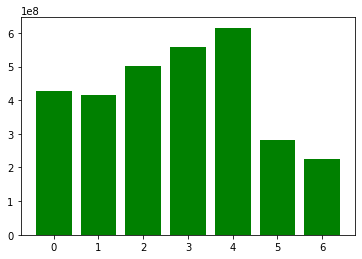

In [57]:
posts = result_group_by_likes_values_array

#Function used in RQ3
print("Digit 1 to insert custom input, other char will execute code with default")
if(input() ==  str(1)):
    print("\n")
    input_t = [] 
    print("Write number of intervals:")
    n = int(input())
    print("Insert "+str(n)+" time intervals: (example: 06:00:00 10:59:59)")
    for i in range(n):
        print("Interval #",i)
        input_t.append(list(input().split()))
else:
    print("\n")
    input_t = [['06:00:00','10:59:59'],['11:00:00','13:59:59'],['14:00:00','16:59:59'],['17:00:00', '19:59:59'],['20:00:00','23:59:59'],['00:00:00','02:59:59'],['03:00:00','05:59:59']]
time_list = []
for interval in input_t:
    row  = []
    row.append(datetime.strptime(interval[0], '%H:%M:%S').time())
    row.append(datetime.strptime(interval[1],'%H:%M:%S').time())
    time_list.append(row)
time_interval(time_list,posts)
plt.show()

##### The same process is repeated but with number of comments:

In [64]:
comments_df['_hour'] = comments_df.cts.apply(lambda i: i.hour).astype(int)
comments_df

,number_comments,cts,_hour
0,0.0,20:06:57,20
1,1.0,09:31:16,9
2,0.0,20:05:03,20
3,0.0,16:27:16,16
4,0.0,10:19:27,10
...,...,...,...
42710192,0.0,15:38:04,15
42710193,0.0,11:28:01,11
42710194,0.0,20:16:37,20
42710195,1.0,20:07:52,20


In [65]:
comments_df['_bin'] = pd.cut(comments_df['_hour'], intervals, include_lowest=True, right=False)
comments_df

,number_comments,cts,_hour,_bin
0,0.0,20:06:57,20,"[20, 24)"
1,1.0,09:31:16,9,"[6, 11)"
2,0.0,20:05:03,20,"[20, 24)"
3,0.0,16:27:16,16,"[14, 17)"
4,0.0,10:19:27,10,"[6, 11)"
...,...,...,...,...
42710192,0.0,15:38:04,15,"[14, 17)"
42710193,0.0,11:28:01,11,"[11, 14)"
42710194,0.0,20:16:37,20,"[20, 24)"
42710195,1.0,20:07:52,20,"[20, 24)"


In [66]:
result_group_by_comments = comments_df \
    .groupby(['_bin'])[['number_comments']] \
    .sum() \
    .reset_index()

result_group_by_comments = result_group_by_comments \
    .astype({'number_comments' : 'int64'})

result_group_by_comments

,_bin,number_comments
0,"[0, 3)",32027925
1,"[3, 6)",23870239
2,"[6, 11)",46784338
3,"[11, 14)",43755376
4,"[14, 17)",52081094
5,"[17, 20)",59538096
6,"[20, 24)",66302700


In [68]:
#Average of comments
result_group_by_comments['average_of_comments_per_hour']=result_group_by_comments['number_comments']/4

result_group_by_comments = result_group_by_comments \
    .astype({'average_of_comments_per_hour' : 'int64'})

In [71]:
result_group_by_comments_values = result_group_by_comments[['_bin','average_of_comments_per_hour']].astype(str)
 
result_group_by_comments_values_array = result_group_by_comments_values.to_numpy().tolist()

result_group_by_comments_values_array

[['[0, 3)', '8006981'],
 ['[3, 6)', '5967559'],
 ['[6, 11)', '11696084'],
 ['[11, 14)', '10938844'],
 ['[14, 17)', '13020273'],
 ['[17, 20)', '14884524'],
 ['[20, 24)', '16575675']]

In [72]:
#Function used in RQ3
def time_interval(time_list,posts):
    counter  = defaultdict()
    for time in time_list:
        interval = time[0].strftime("%H:%M:%S")+" "+time[1].strftime("%H:%M:%S")
        counter[interval] = 0

    for _bin, value in posts:
        if _bin == '[0, 3)':
            counter['00:00:00 02:59:59'] = value
        elif _bin == '[3, 6)':
            counter['03:00:00 05:59:59'] = value 
        elif _bin == '[6, 11)':
            counter['06:00:00 10:59:59'] = value 
        elif _bin == '[11, 14)':
            counter['11:00:00 13:59:59'] = value 
        elif _bin == '[14, 17)':
            counter['14:00:00 16:59:59'] = value 
        elif _bin == '[17, 20)':
            counter['17:00:00 19:59:59'] = value 
        elif _bin == '[20, 24)':
            counter['20:00:00 23:59:59'] = value 
    for key in counter:
        counter[key] = int(counter[key])
    hist  = plt.bar(range(len(list(counter.keys()))), counter.values(), color='g')
    print("Histogram with the avergae quantity of number of likes for each interval given as input:")
    i= 0
    for key in counter.keys():
        print( "Interval "+str(i)+" = "+key)
        i+=1

##### As can be seen in the histogram, interval 4 is the one that obtains the highest number of comments as well as the highest number of likes.

Digit 1 to insert custom input, other char will execute code with default


Histogram with the avergae quantity of number of likes for each interval given as input:
Interval 0 = 06:00:00 10:59:59
Interval 1 = 11:00:00 13:59:59
Interval 2 = 14:00:00 16:59:59
Interval 3 = 17:00:00 19:59:59
Interval 4 = 20:00:00 23:59:59
Interval 5 = 00:00:00 02:59:59
Interval 6 = 03:00:00 05:59:59


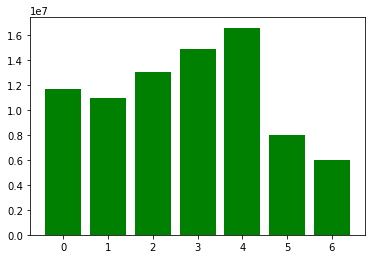

In [73]:
posts = result_group_by_comments_values_array

#Function used in RQ3
print("Digit 1 to insert custom input, other char will execute code with default")
if(input() ==  str(1)):
    print("\n")
    input_t = [] 
    print("Write number of intervals:")
    n = int(input())
    print("Insert "+str(n)+" time intervals: (example: 06:00:00 10:59:59)")
    for i in range(n):
        print("Interval #",i)
        input_t.append(list(input().split()))
else:
    print("\n")
    input_t = [['06:00:00','10:59:59'],['11:00:00','13:59:59'],['14:00:00','16:59:59'],['17:00:00', '19:59:59'],['20:00:00','23:59:59'],['00:00:00','02:59:59'],['03:00:00','05:59:59']]
time_list = []
for interval in input_t:
    row  = []
    row.append(datetime.strptime(interval[0], '%H:%M:%S').time())
    row.append(datetime.strptime(interval[1],'%H:%M:%S').time())
    time_list.append(row)
time_interval(time_list,posts)
plt.show()